In [1]:
import numpy as np
import pandas as pd 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score


In [2]:
np.random.seed(110243143)
data = np.loadtxt('EMG.csv',skiprows=1,delimiter=',')

In [3]:
pdData = pd.read_csv('EMG.csv')
pdData.head()
pdData.isnull().any()


S1_0      False
S2_0      False
S3_0      False
S4_0      False
S5_0      False
          ...  
S5_7      False
S6_7      False
S7_7      False
S8_7      False
Target    False
Length: 65, dtype: bool

In [4]:
y = pdData.Target
X = pdData.drop('Target', axis=1)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [6]:
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()

nb_model.fit(X_train, y_train.ravel())

GaussianNB(priors=None, var_smoothing=1e-09)

In [7]:
from sklearn import metrics 
from sklearn.model_selection import GridSearchCV

def analyse_results(x, y, model, title):
    predict = model.predict(x)
    print ("=== " + title + " ===")
    
    if type(model) is GridSearchCV:
        print("Best values:{0}".format(model.best_estimator_))
    
    print("Accuracy: {0}".format(metrics.accuracy_score(y, predict)))
    
    print("Classification Report")
    print(metrics.classification_report(y, predict, labels=[0,1]))
    print()

In [8]:

analyse_results(X_train, y_train, nb_model, "Naive Bayese Training Data")
analyse_results(X_test, y_test, nb_model, "Naive Bayese Test Data")

=== Naive Bayese Training Data ===
Accuracy: 0.8877114108327981
Classification Report
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      2327
           1       0.84      0.96      0.89      2324

   micro avg       0.88      0.94      0.91      4651
   macro avg       0.88      0.94      0.91      4651
weighted avg       0.88      0.94      0.91      4651


=== Naive Bayese Test Data ===
Accuracy: 0.8771404109589042
Classification Report
              precision    recall  f1-score   support

           0       0.91      0.92      0.92       583
           1       0.82      0.95      0.88       579

   micro avg       0.86      0.93      0.90      1162
   macro avg       0.86      0.93      0.90      1162
weighted avg       0.86      0.93      0.90      1162




In [9]:
import pandas as pd
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
import numpy as np

from time import time
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix, accuracy_score


def vprint(obj, max_row=None, max_col=None):
    ''' print object with custom max display vars '''
    with pd.option_context('display.max_rows', max_row, 'display.max_columns', max_col):
        print(obj)
        
def pprint(name, data):
    ''' print label and val '''
    print("{0}: {1}".format(name, data))

def show_roc_plot(X_test, y_test, model):
    ''' plot roc curve graph '''
    # Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
    preds = model.predict_proba(X_test)[:,1]

    # Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
    fpr, tpr, _ = roc_curve(y_test, preds)

    # Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
    roc_auc = auc(fpr,tpr)

    # Plot the ROC Curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
        
def plot_confusion_matrix(y_result, y_test, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(y_result, y_test)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def print_model_report(model, X_test, y_test, y_result, condensed, roc=True, cmap=None):
    #print("Model: \n\n {0} \n\n ".format(model))
    
    if cmap is None:
        cmap = plt.cm.Blues
        
    print(classification_report(y_test, y_result, target_names=['Closed Won', 'Closed Lost'], ))
    
    if not condensed:
        plot_confusion_matrix(y_result, y_test, classes=['Closed Won', 'Closed Lost'], normalize=True, cmap=cmap)
    
    if roc and not condensed:
        show_roc_plot(X_test, y_test, model)
        
def fit_and_evaluate_model(X_train, y_train, X_test, y_test, model, print_report=True, report_test=True, report_train=False, roc=True, condensed=False):
    fit_start = time()
    model.fit(X_train, y_train)
    fit_end = time()
    
    if print_report:
        predict_start = time()
        y_pred = model.predict(X_test)
        predict_end = time()
        
        fit_time = fit_end - fit_start
        predict_time = predict_end - predict_start
        
        print('training time: {0} s'.format(fit_time))
        print('testing time: {0} s'.format(predict_time))
        print()
        print('model params:')
        
        if not condensed:
            if type(model) == 'GridSearch':
                model_params = model.get_best_estimator_.get_params()
            else:
                model_params = model.get_params()

            for k, v in model_params.items():
                print('{0}: {1}'.format(k,str(v)))
            
        print()
        
        if report_train:
            print('Training Data')
            print()
            y_pred_train = model.predict(X_train)
            pprint('Training accuracy', accuracy_score(y_train, y_pred_train))
            print_model_report(model, X_train, y_train, y_pred_train, condensed, roc=True)
        
        if report_test:
            print('Test Data')
            print()
            pprint('Test accuracy', accuracy_score(y_test, y_pred))
            print_model_report(model, X_test, y_test, y_pred, condensed, roc=True)
        
    
    return model

def fit_and_evaluate_model_accuracy(X_train, y_train, X_test, y_test, model):
    
    start_training = time()
    model.fit(X_train, y_train)
    end_training = time()
    
    start_prediction = time()
    y_pred = model.predict(X_test)
    end_prediction = time()
    
    y_pred_train = model.predict(X_train)
    
    train_time = end_training - start_training
    prediction_time = end_prediction - start_prediction
    
    train_accuracy = accuracy_score(y_true=y_train, y_pred=y_pred_train)
    test_accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
    
    return [train_accuracy, test_accuracy, train_time, prediction_time]


/Users/patrick/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


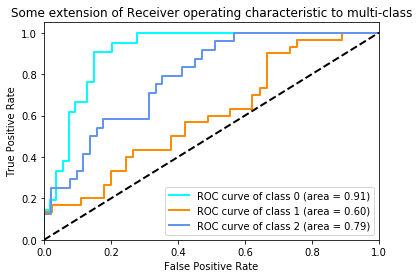

In [10]:

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

# Import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target
lw = 2


# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()


colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [36]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=9)
neigh.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='uniform')

In [37]:

analyse_results(X_train, y_train, neigh, "Naive Bayese Training Data")
analyse_results(X_test, y_test, neigh, "Naive Bayese Test Data")

=== Naive Bayese Training Data ===
Accuracy: 0.4266666666666667
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.52      0.65        29
           1       0.56      0.25      0.34        20

   micro avg       0.77      0.41      0.53        49
   macro avg       0.72      0.38      0.50        49
weighted avg       0.75      0.41      0.53        49
 samples avg       0.27      0.27      0.27        49


=== Naive Bayese Test Data ===
Accuracy: 0.21333333333333335
Classification Report
              precision    recall  f1-score   support

           0       0.64      0.43      0.51        21
           1       0.31      0.13      0.19        30

   micro avg       0.48      0.25      0.33        51
   macro avg       0.48      0.28      0.35        51
weighted avg       0.45      0.25      0.32        51
 samples avg       0.17      0.17      0.17        51




/Users/patrick/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/patrick/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/patrick/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/patrick/opt/an

[Text(133.92000000000002, 190.26, 'X[2] <= 2.35\ngini = 0.439\nsamples = 75\nvalue = [[46, 29]\n[55, 20]\n[49, 26]]'),
 Text(66.96000000000001, 135.9, 'gini = 0.0\nsamples = 29\nvalue = [[0, 29]\n[29, 0]\n[29, 0]]'),
 Text(200.88000000000002, 135.9, 'X[2] <= 5.05\ngini = 0.328\nsamples = 46\nvalue = [[46, 0]\n[26, 20]\n[20, 26]]'),
 Text(133.92000000000002, 81.53999999999999, 'X[617] <= 1.23\ngini = 0.11\nsamples = 22\nvalue = [[22, 0]\n[2, 20]\n[20, 2]]'),
 Text(66.96000000000001, 27.180000000000007, 'gini = 0.0\nsamples = 20\nvalue = [[20, 0]\n[0, 20]\n[20, 0]]'),
 Text(200.88000000000002, 27.180000000000007, 'gini = 0.0\nsamples = 2\nvalue = [[2, 0]\n[2, 0]\n[0, 2]]'),
 Text(267.84000000000003, 81.53999999999999, 'gini = 0.0\nsamples = 24\nvalue = [[24, 0]\n[24, 0]\n[0, 24]]')]

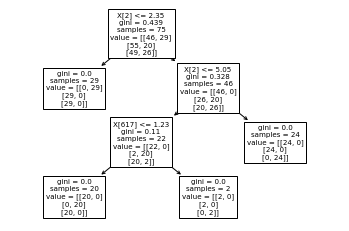

In [24]:
from sklearn import tree
clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
tree.plot_tree(clf) 


In [38]:

analyse_results(X_train, y_train, clf, "Naive Bayese Training Data")
analyse_results(X_test, y_test, clf, "Naive Bayese Test Data")

=== Naive Bayese Training Data ===
Accuracy: 1.0
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00        20

   micro avg       1.00      1.00      1.00        49
   macro avg       1.00      1.00      1.00        49
weighted avg       1.00      1.00      1.00        49
 samples avg       0.65      0.65      0.65        49


=== Naive Bayese Test Data ===
Accuracy: 0.8666666666666667
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       0.79      0.90      0.84        30

   micro avg       0.87      0.94      0.91        51
   macro avg       0.90      0.95      0.92        51
weighted avg       0.88      0.94      0.91        51
 samples avg       0.64      0.64      0.64        51




/Users/patrick/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/patrick/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/patrick/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/patrick/opt/an